Let's establish a baseline we can compare performance to. For now, let's look at whole objects.

Ideas for later:
* Split objects into areas and look at those areas individually to have a higher OT to porosity spread

Thoughts:
* The original paper about OT data doesn't quantify their results. AFAIK there's noone who tried to quantify things, which is making things harder for me.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from sklearn import cluster, linear_model

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()

powderthickness = 80
objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity"])
objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
ims = np.array([np.array(plt.imread(path)) for path in paths_sorted])

paths = pathlib.Path('./OT data 80 um/max').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
maxs = np.array([np.array(plt.imread(path)) for path in paths_sorted])
# Don't touch original
integrals = np.copy(ims)

In [7]:
objectwidth = 83
objectheight = 122
xspacing = 134
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])


Idea from Arnulf (kind of): let's look at how the different components of VED contribute to porosity.

In [24]:
dfc = objectinfo.copy()
print(dfc.sort_values(by=['VED', "Porosity"]).to_string())


   Object        VED    P     S     H  Porosity
21    H22  16.707656  250  1336  0.14    19.137
1      H2  21.634615  270  1200  0.13     4.847
24    H25  23.390719  350  1336  0.14     2.480
15    H16  25.690210  300  1327  0.11     0.844
7      H8  26.442308  330  1200  0.13     1.002
13    H14  26.785714  300  1000  0.14     0.641
18    H19  28.522727  251  1000  0.11     0.286
23    H24  29.238398  250  1336  0.08     0.085
6      H7  31.250000  270  1200  0.09     0.051
9     H10  32.451923  270   800  0.13     0.071
22    H23  33.616609  250   664  0.14     0.088
17    H18  34.090909  300  1000  0.11     0.024
12    H13  34.090909  300  1000  0.11     0.033
8      H9  34.090909  300  1000  0.11     0.067
2      H3  34.090909  300  1000  0.11     0.071
4      H5  34.090909  300  1000  0.11     0.092
11    H12  34.090909  300  1000  0.11     0.105
3      H4  38.194444  330  1200  0.09     0.046
16    H17  39.659091  349  1000  0.11     0.045
5      H6  39.663462  330   800  0.13   

As we can see, linear regression doesn't work. Not sure why I tried it...

[array([10077196614, 11586588429, 12169198190, 13404359070, 13434723295,
       13554775893, 15420629787, 15993785802, 16967471815, 17797276737,
       17914077201, 18169685448, 18295149209, 18416016506, 18430008848,
       18663863395, 18714084584, 20333802641, 20472454293, 21194258114,
       21547465266, 25300360721, 27893775675, 29879624702, 29949938507,
       35986617485, 38596768494, 61445618770], dtype=uint64), array([19.137,  2.48 ,  4.847,  0.641,  1.002,  0.844,  0.085,  0.286,
        0.051,  0.033,  0.071,  0.024,  0.105,  0.067,  0.092,  0.071,
        0.088,  0.049,  0.045,  0.036,  0.046,  0.046,  0.055,  0.1  ,
        0.037,  0.273,  0.044,  0.456]), array([ 2.21286037,  2.06709845,  2.01083584,  1.8915564 ,  1.88862412,
        1.87703065,  1.69684519,  1.64149553,  1.54746671,  1.46733247,
        1.45605305,  1.43136897,  1.41925294,  1.40758079,  1.40622955,
        1.38364622,  1.37879636,  1.22238024,  1.20899065,  1.13928608,
        1.10517688,  0.74275988,  0

Text(0.5, 1.0, 'Porosity and OT sum for each of the 28 items')

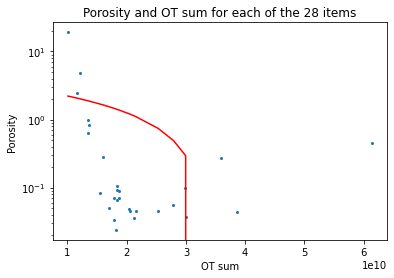

In [8]:
from sklearn import linear_model
from scipy.optimize import curve_fit
model = linear_model.Lasso()
X = np.array([np.sum(integrals[:, object.ystart:object.yend, object.xstart:object.xend])
            for index, object in coorddf.iterrows()]).reshape(-1, 1)
y = np.array(objectinfo.filter(items=['Porosity'])).reshape(-1, 1)
model.fit(X, y)
line = model.predict(X)
inds = X[:, 0].argsort()
sortedX = X[:, 0][inds]
sortedLine = line[inds]
sortedY = y[:, 0][inds]
table = [sortedX, sortedY, sortedLine]
print(table)
# print(sortedX)

plt.scatter(X, y, s=4)
plt.plot(sortedX, sortedLine, 'r')
plt.yscale("log")
plt.ylabel("Porosity")
plt.xlabel("OT sum")
plt.title("Porosity and OT sum for each of the 28 items")


Let's look at one of the images

Let's try fitting a second-degree polynominal instead. Spoiler: it doens't work great either.

[29949938507 12169198190 18663863395 21547465266 18430008848 20333802641
 16967471815 13434723295 18416016506 17914077201 38596768494 18295149209
 17797276737 13404359070 29879624702 13554775893 20472454293 18169685448
 15993785802 27893775675 35986617485 10077196614 18714084584 15420629787
 11586588429 25300360721 21194258114 61445618770]
[ 0.037  4.847  0.071  0.046  0.092  0.049  0.051  1.002  0.067  0.071
  0.044  0.105  0.033  0.641  0.1    0.844  0.045  0.024  0.286  0.055
  0.273 19.137  0.088  0.085  2.48   0.046  0.036  0.456]
y = -0.00000 * x + 0.00000 * x^2 + -0.00000


Text(0.5, 1.0, 'Porosity and OT sum for each of the 28 items')

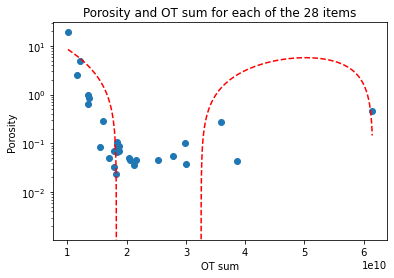

In [9]:
from scipy.optimize import curve_fit
from numpy import arange
x = np.array([np.sum(integrals[:, object.ystart:object.yend, object.xstart:object.xend])
              for index, object in coorddf.iterrows()])
y = np.array(objectinfo.filter(items=['Porosity'])).flatten()

print(x)
print(y)


def objective(x, a, b, c, d):
	return (a * x) + (b * x**2) + (c * x**3) + d

popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c, d = popt
print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))
# plot input vs output
plt.scatter(x, y)
x_line = arange(min(x), max(x), 10000000)
y_line = objective(x_line, a, b, c, d)
plt.plot(x_line, y_line, '--', color='red')
plt.yscale("log")
plt.yscale("log")
plt.ylabel("Porosity")
plt.xlabel("OT sum")
plt.title("Porosity and OT sum for each of the 28 items")

New idea: non-linear regression. Should work, right?

/Users/erik/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/erik/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/erik/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Text(0.5, 1.0, 'Porosity and OT sum for each of the 28 items')

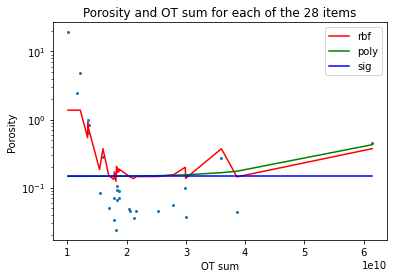

In [10]:
from sklearn.svm import SVR
from scipy.optimize import curve_fit
c = 1
svr_rbf = SVR(kernel="rbf", C=c, epsilon=0.1, gamma='auto')
svr_sig = SVR(kernel="sigmoid", C=c, epsilon=0.1, gamma='auto')
svr_poly = SVR(kernel="poly", C=c, degree=5)
X = np.array([np.sum(integrals[:, object.ystart:object.yend, object.xstart:object.xend])
              for index, object in coorddf.iterrows()]).reshape(-1, 1)
y = np.array(objectinfo.filter(items=['Porosity'])).reshape(-1, 1)
inds = X[:, 0].argsort()
svr_rbf.fit(X, y)
svr_poly.fit(X, y)
svr_sig.fit(X, y)
line1 = svr_rbf.predict(X)[inds]
line2 = svr_poly.predict(X)[inds]
line3 = svr_sig.predict(X)[inds]
sortedX = X[:, 0][inds]
sortedY = y[:, 0][inds]
table = [sortedX, sortedY, line1, line2, line3]
# print(table)

plt.scatter(X, y, s=4)
plt.plot(sortedX, line1, 'r', label='rbf')
plt.plot(sortedX, line2, 'g', label='poly')
plt.plot(sortedX, line3, 'b', label='sig')
plt.legend()
plt.yscale("log")
plt.ylabel("Porosity")
plt.xlabel("OT sum")
plt.title("Porosity and OT sum for each of the 28 items")


I'm not happy with the overfitting here. How about we look at it layer by layer and create more data?

In [29]:
from sklearn.svm import SVR
c = 1
svr_rbf = SVR(kernel="rbf", C=c, epsilon=0.1, gamma='auto')
svr_sig = SVR(kernel="sigmoid", C=c, epsilon=0.1, gamma='auto')
svr_poly = SVR(kernel="poly", C=c, degree=5)
dfOtPerLayer = pd.DataFrame([], columns=['Object', 'Layer', 'Porosity', 'OT'])
for layernumber, layer in enumerate(integrals[1:187]):
    for index, object in coorddf.iterrows():
        ot = np.sum(layer[object.ystart:object.yend, object.xstart:object.xend])
        porosity = objectinfo.iloc[index].Porosity
        dfOtPerLayer.loc[-1] = [index+1, layernumber+1, porosity, ot]
        dfOtPerLayer.index = dfOtPerLayer.index + 1
        # df.append({'Object': index+1, 'Layer':layernumber+1, 'Porosity':porosity, 'OT':ot}, ignore_index=True)


In [ ]:
plt.scatter(dfOtPerLayer.filter(items=['OT']), dfOtPerLayer.filter(
    items=['Porosity']), s=3, c='b')
plt.scatter(X/186, y, s=10, c='r')
# X = np.array([np.sum(integrals[:, object.ystart:object.yend, object.xstart:object.xend])
#               for index, object in coorddf.iterrows()]).reshape(-1, 1)
# y = np.array(objectinfo.filter(items=['Porosity'])).reshape(-1, 1)
# inds = X[:, 0].argsort()
X = dfOtPerLayer.filter(items=['OT']).to_numpy()
Y = dfOtPerLayer.filter(items=['Porosity']).to_numpy()
svr_rbf.fit(X, Y)
svr_poly.fit(X, Y)
svr_sig.fit(X, Y)
# line1 = svr_rbf.predict(X)[inds]
# line2 = svr_poly.predict(X)[inds]
# line3 = svr_sig.predict(X)[inds]
# sortedX = X[:, 0][inds]
# sortedY = y[:, 0][inds]
# table = [sortedX, sortedY, line1, line2, line3]
# # print(table)

# plt.scatter(X, y, s=4)
# plt.plot(sortedX, line1, 'r', label='rbf')
# plt.plot(sortedX, line2, 'g', label='poly')
# plt.plot(sortedX, line3, 'b', label='sig')
plt.legend()
plt.yscale("log")
plt.ylabel("Porosity")
plt.xlabel("OT sum")


Ok that may not work. Let's look at variance of OT and average OT reading together with the other information about the objects.

Somewhat interestingly, there seems to be no strong correlation between average OT or variance OT and porosity

In [35]:
objectinfo['avg_ot'] = 0
objectinfo['var_ot'] = 0
for index, object in objectinfo.iterrows():
    dataz = dfOtPerLayer.loc[dfOtPerLayer['Object'] == index+1]['OT']
    print(dataz)
    objectinfo.at[index, 'avg_ot'] = np.average(dataz)
    objectinfo.at[index, 'var_ot'] = np.var(dataz)
print(objectinfo.sort_values(by=['VED', "Porosity"]))

    


   Object        VED    P     S     H  Porosity     avg_ot            var_ot
21    H22  16.707656  250  1336  0.14    19.137   53628329     9425798815217
1      H2  21.634615  270  1200  0.13     4.847   64664863    53308831960343
24    H25  23.390719  350  1336  0.14     2.480   61437049    80841428532169
15    H16  25.690210  300  1327  0.11     0.844   72004383    85969102591744
7      H8  26.442308  330  1200  0.13     1.002   71221122   122947566981727
13    H14  26.785714  300  1000  0.14     0.641   71134564   174302502751551
18    H19  28.522727  251  1000  0.11     0.286   85186538   145531112408529
23    H24  29.238398  250  1336  0.08     0.085   82063567    35742043567829
6      H7  31.250000  270  1200  0.09     0.051   90305196    78006784975316
9     H10  32.451923  270   800  0.13     0.071   94933335   181766134621233
22    H23  33.616609  250   664  0.14     0.088   99159377   125811118355720
17    H18  34.090909  300  1000  0.11     0.024   96407286   164823315055763

Ok that may not work out.

Let's zoom out. What are we trying to accomplish?

1. Predict the occurance of defects using in-situ monitoring (i.e. we wanna be able to see if defects arise). Specifically, we wanna see if pores arise and preferably which kind of pore.
2. An existing paper showed there is overlap between OT images and pores, but did not evaluate the effectiveness of OT as a prediction tool. Our data is more granular, meaning we can't (right now) say "here's a pore" but we can say "this is the porosity of the whole object"
3. We want to be able to say something about the porosity of an object (or an area of an object) given OT data for the object (or area)
4. One tool we can use for that is clustering. How do we go from cluster(s) to porosity?
* Correlate number of clusters with porosity?
* Correlate size of cluster with porosity?
* Correlate area of clusters with porosity?
4.1. How do we account for clusters persisting between layers having greater weight?
5. If we zoom out again and consider other ML approaches, what may be suitable?
* Looking at OT sum + variance with regression analysis tools
* CNNs may have a hard time because of the data set size, but maybe we can use headless imagenet?

For starters, let's create plots with the KPIs we think may be relevant and see how well they correlate with porosity?

In [12]:
pictures = np.copy(integrals)
start_layer = 87
end_layer = 99
layersOfInterest = pictures[start_layer:end_layer]
points = np.array([[t, x, y, value]
                  for (t, x, y), value in np.ndenumerate(layersOfInterest)])
# for threshold in thresholds:
#     for (t, x, y), value in np.ndenumerate(pictures):
#         if(value > threshold):
#             points.append([t, threshold, x, y])
# May need to speed this up a bit. How about we first
# [ enumerate(picture) for threshold in thresholds]
df = pd.DataFrame(points, columns=['layer', 'x', 'y', 'value'])

In [20]:
# Let's look at the OT reading of each object, and the OT reading of all objects
# Undersök porositet för andra parametrar än bara VED för att förstå vad vi ser.
imageNo = 93
for index, object in coorddf.iterrows():
    print(integrals[:, object.ystart:object.yend,
          object.xstart:object.xend])
    print(np.sum(integrals[:, object.ystart:object.yend,
          object.xstart:object.xend], axis=0),)
    break
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("Object " + str(index+1) + " (" + str(object.Porosity) +
                 "% porosity) integral image " + str(imageNo))
    ax1.set_title("Absolute reading")
    ax1.imshow(maxs[imageNo][object.ystart:object.yend,
               object.xstart:object.xend], vmin=0, vmax=65535)
    ax2.set_title("Relative reading")
    ax2.imshow(maxs[imageNo][object.ystart:object.yend,
               object.xstart:object.xend])
    ax3.set_title("Histogram")
    ax3.hist(maxs[imageNo, object.ystart:object.yend, object.xstart:object.xend].flatten(
    ), bins=100, color='r', range=(0, 65535))
    ax3.set_yscale('log')
    plt.figure()


[[[    0     0     0 ...  1045  1408   728]
  [    0     0    70 ...  1039  1207   810]
  [    0    62    81 ...  1153  1057   681]
  ...
  [ 7008 12514 22460 ... 27264 14195  6283]
  [ 6086  9017 13887 ... 17227  9817  4820]
  [ 5284  6517  8192 ...  8480  5414  3235]]

 [[  970   908  1093 ...     0     0     0]
  [  675  1018  1279 ...     0     0     0]
  [  924  1127  1334 ...     0     0     0]
  ...
  [ 2261  4593  9799 ... 16205 10645  6365]
  [ 1712  3036  5587 ... 11040  8163  5629]
  [ 1331  1847  2753 ...  6316  5283  4367]]

 [[  374   312   364 ...   986   901   890]
  [  403   381   368 ...  1094   860   660]
  [  409   406   390 ...   977  1104   961]
  ...
  [ 2987  5142  9893 ... 14688  8013  3371]
  [ 2420  3403  5778 ...  8773  5020  2295]
  [ 1795  2276  3144 ...  3817  2475  1353]]

 ...

 [[    0     0     0 ...     0     0     0]
  [    0     0     0 ...     0     0     0]
  [    0     0     0 ...     0     0     0]
  ...
  [    0     0     0 ...     0     0    

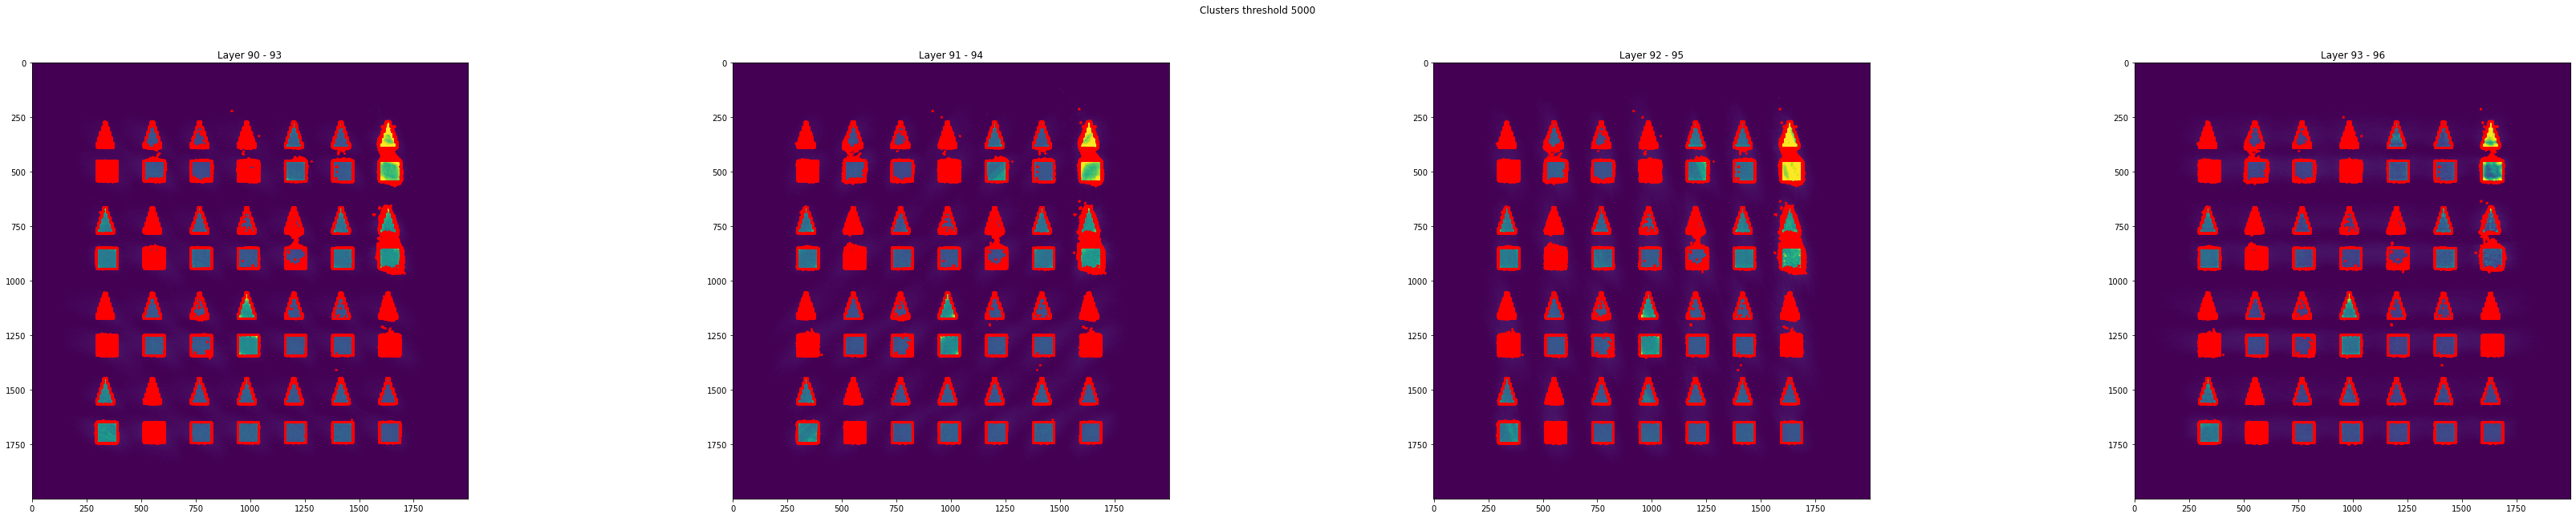

<Figure size 432x288 with 0 Axes>

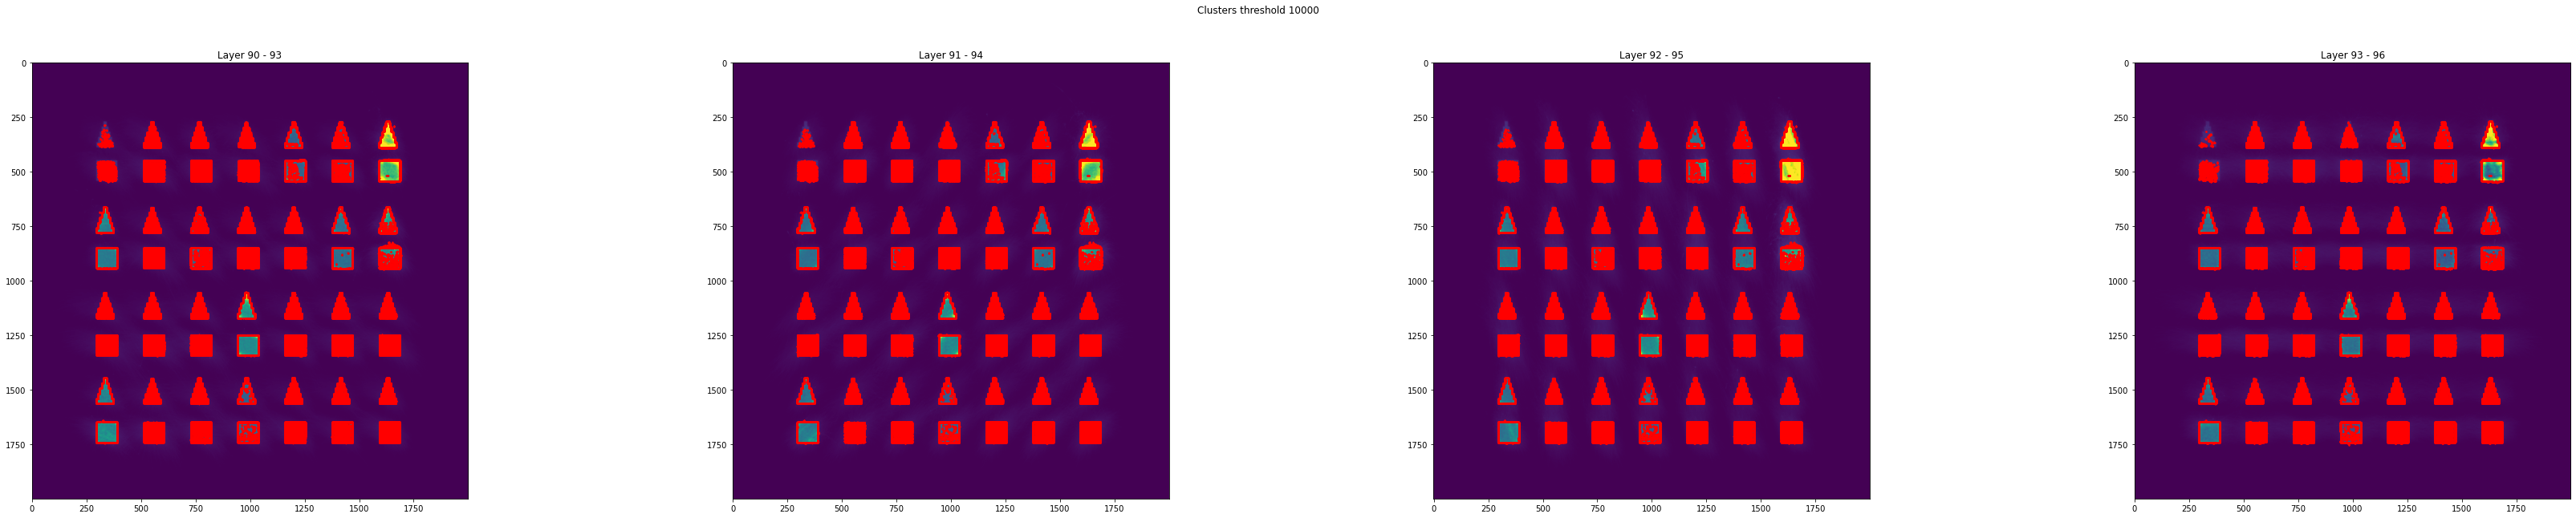

<Figure size 432x288 with 0 Axes>

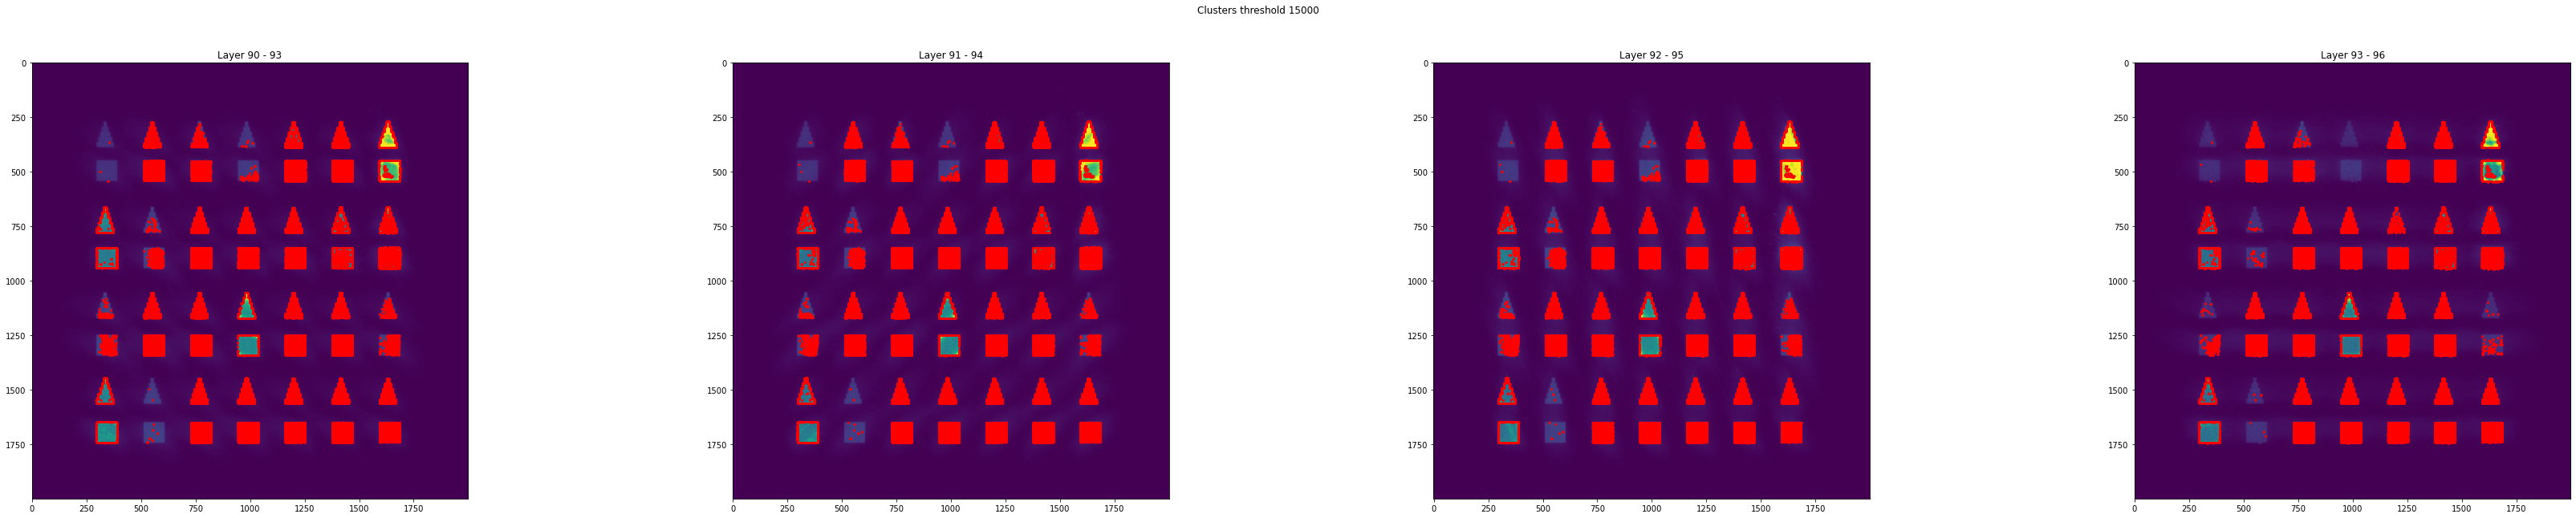

<Figure size 432x288 with 0 Axes>

In [13]:
# The time complexity here is disgusting
# How about we do window size 4, print all?
window_size = 4
thresholds = [(5000, 10000), (10000, 15000), (15000, 20000)]
eps = 1.5
minpts = 5
clusterings = pd.DataFrame(columns=['StartLayer', 'x', 'y', 'Cluster'])
dbscan = cluster.DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1)
results = []
# Pseudocode
# For each threshold, conduct dbscan. Plot the clusters identified on the image. Ignore the noise.
# Start with a single threshold
for (mint, maxt) in thresholds:
    for i in range(0, end_layer - start_layer - window_size + 1):
        filterArray = (df.layer >= i) & (
            df.layer < i+window_size) & (df.value >= mint) & (df.value <= maxt)
        dataToCluster = df[filterArray].filter(items=['x', 'y'])
        if len(dataToCluster.index) == 0:
            continue
        result = dbscan.fit_predict(dataToCluster)
        dataToCluster.insert(loc=0, column="Cluster", value=result)
        dataToCluster.insert(loc=0, column="StartLayer", value=i + start_layer)
        dataToCluster.insert(loc=0, column="Threshold", value=mint)
        results.append(dataToCluster)
clusterings = pd.concat(results)
for (threshold, _) in thresholds:
    noOfPlots = window_size
    fig, axs = plt.subplots(1, noOfPlots, figsize=(60, 10))
    fig.suptitle("Clusters threshold " + str(threshold))
    for index, ax in enumerate(axs):
        currentStartLayer = (start_layer + end_layer) // 2 - \
            window_size + index + 1
        ax.set_title("Layer " + str(currentStartLayer) +
                     " - " + str(currentStartLayer + window_size - 1))
        pointsToShow = clusterings[(clusterings.StartLayer == currentStartLayer) & (
            clusterings.Cluster != -1) & (clusterings.Threshold == threshold)]
        ax.scatter(pointsToShow.filter(items=['y']), pointsToShow.filter(
            items=['x']), s=1, c='r')
        ax.imshow(pictures[currentStartLayer])
    plt.figure()
# How do we show the result?
# Print them on a canvas?
# Where are we at exactly? Show correlation between various metrics and the porosity? Or (optionally), feed them into an SL model? But we don't have enough data?
# I feel like doing data science on this doesn't make sense
# Revise the blackout paper. What was their approach? Did they just have a hypothesis they wanted to test?
# What do I wanna ask her? How do we view this?
# This is shoehorning. But I'm thinking, we should be able to say something about the porosity given an image right?
# We can see the difference, how do we quantify it?
# Can we quantify noisyness? Can we create metrics of noise?
# What does the sum of each object look like? What does the sum of everything look like?
